In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

/d/alecoz/miniconda3/envs/alc/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635068699003/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


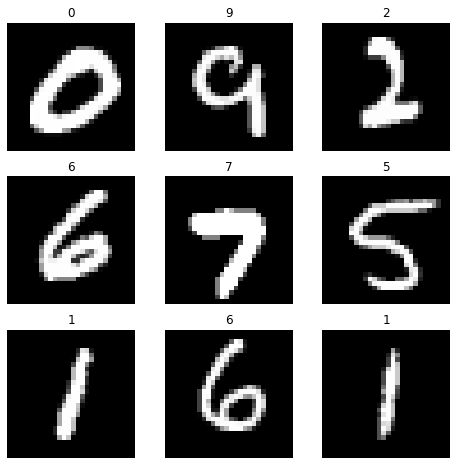

In [3]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [4]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [5]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
        y = self.net(x)
        return y


In [6]:
def train(dataloader, model, loss_function, optimizer):

    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print('[{}/{}] loss: {}'.format(batch*len(X), size, loss))


def test(dataloader, model, loss_function):

    cum_loss, correct_pred = 0, 0
    for X, y in dataloader:

        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            # Compute prediction, loss and correct predictions
            y_pred = model(X)
            loss = loss_function(y_pred, y)
            correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()

            cum_loss += loss
            correct_pred += correct

    average_loss = cum_loss / len(dataloader)
    average_accuracy = correct_pred / len(dataloader.dataset)

    print('Test error: {}\nAccuracy {}\n'.format(average_loss, average_accuracy))

In [7]:
model = NeuralNetwork(input_dim=train_data[0][0].squeeze().numel(), output_dim=10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
epochs = 10

test(test_dataloader, model, loss_function)
for e in range(1, epochs+1):
    print(f'Epoch {e}/{epochs}\n-------------------')
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function)

Test error: 2.3077805042266846
Accuracy 0.1041

Epoch 1/10
-------------------
[0/60000] loss: 2.314976692199707
[6400/60000] loss: 0.2862808406352997
[12800/60000] loss: 0.20679853856563568
[19200/60000] loss: 0.24893802404403687
[25600/60000] loss: 0.13265657424926758
[32000/60000] loss: 0.3126378655433655
[38400/60000] loss: 0.1366458535194397
[44800/60000] loss: 0.22350583970546722
[51200/60000] loss: 0.31205320358276367
[57600/60000] loss: 0.18257275223731995
Test error: 0.13885830342769623
Accuracy 0.9562

Epoch 2/10
-------------------
[0/60000] loss: 0.08305042237043381
[6400/60000] loss: 0.0634264424443245
[12800/60000] loss: 0.12921051681041718
[19200/60000] loss: 0.09104133397340775
[25600/60000] loss: 0.06994938105344772
[32000/60000] loss: 0.11021795123815536
[38400/60000] loss: 0.07782070338726044
[44800/60000] loss: 0.14081861078739166
[51200/60000] loss: 0.13212577998638153
[57600/60000] loss: 0.10728442668914795
Test error: 0.1115833967924118
Accuracy 0.9645

Epoch 3/1